# Final Project



In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



## Stage 1
Prep the London data file

In [3]:
london_boroughs = pd.read_csv('/Users/Paul/Coding/IBM Courses Info/Capstone/LondonBoroughs.csv')

print (london_boroughs)    

                   Borough                                Local authority  \
0     Barking and Dagenham    Barking and Dagenham London Borough Council   
1                   Barnet                  Barnet London Borough Council   
2                   Bexley                  Bexley London Borough Council   
3                    Brent                   Brent London Borough Council   
4                  Bromley                 Bromley London Borough Council   
5                   Camden                  Camden London Borough Council   
6                  Croydon                 Croydon London Borough Council   
7                   Ealing                  Ealing London Borough Council   
8                  Enfield                 Enfield London Borough Council   
9                Greenwich               Greenwich London Borough Council   
10                 Hackney                 Hackney London Borough Council   
11  Hammersmith and Fulham  Hammersmith and Fulham London Borough Council   

## Create Bar Chart to analyse data

In [8]:
lon_pop = london_boroughs[['Borough', 'Population']] 

lon_pop = lon_pop.sort_values('Population', ascending=True)

print (lon_pop.head())

                   Borough  Population
18  Kensington and Chelsea    155594.0
19    Kingston upon Thames    166793.0
11  Hammersmith and Fulham    178685.0
25    Richmond upon Thames    191365.0
0     Barking and Dagenham    194352.0


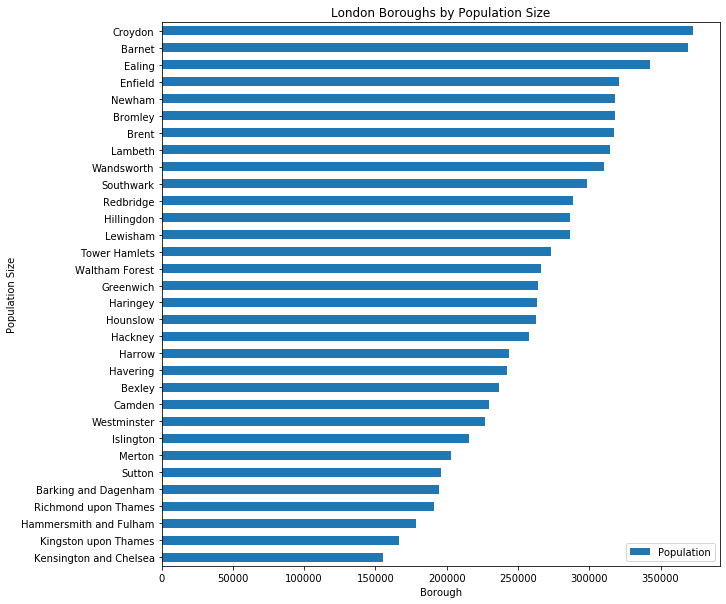

In [9]:
lon_pop.plot(kind='barh', figsize=(10, 10), x='Borough')

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Population Size') # add y-label to the plot
plt.title('London Boroughs by Population Size') # add title to the plot

plt.show()

Population density


In [10]:
london_boroughs['Population'] = london_boroughs['Population'].astype(float)

london_boroughs["Population_Density"] = (london_boroughs["Population"]/1000) / london_boroughs["Area sq_miles"]

lon_popden = london_boroughs[['Borough', 'Population_Density']] 

lon_popden = lon_popden.sort_values('Population_Density', ascending=True)

print (lon_popden.head())



                 Borough  Population_Density
4                Bromley            5.483854
14              Havering            5.584314
15            Hillingdon            6.420551
25  Richmond upon Thames            8.631710
8                Enfield           10.098425


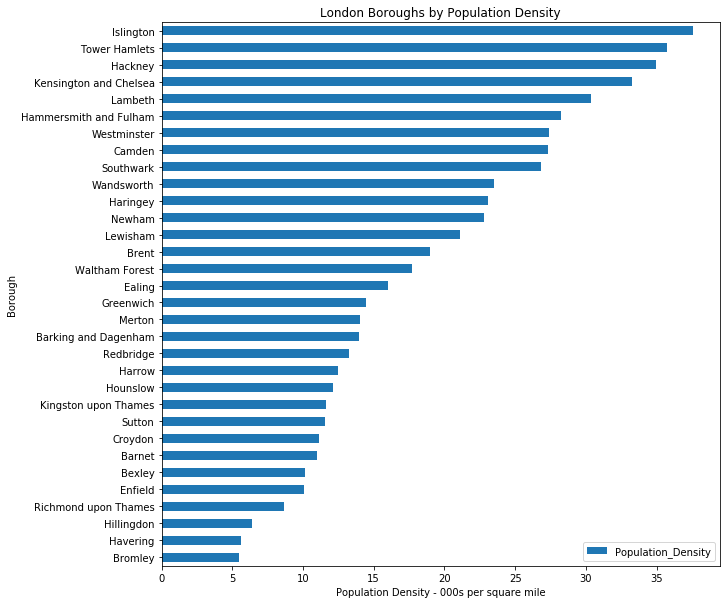

In [11]:
lon_popden.plot(kind='barh', figsize=(10, 10), x='Borough')

plt.xlabel('Population Density - 000s per square mile') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('London Boroughs by Population Density') # add title to the plot

plt.show()

## Stage 2

Analyse each Borough. 

Drop columsn that might interfer with clustering


In [12]:
london = london_boroughs[['Borough', 'Latitude', 'Longitude']] 
print (london.head())

                Borough  Latitude  Longitude
0  Barking and Dagenham   51.5607     0.1557
1                Barnet   51.6252    -0.1517
2                Bexley   51.4549     0.1505
3                 Brent   51.5588    -0.2817
4               Bromley   51.4039     0.0198


In [13]:
CLIENT_ID = 'T1V0AEHTGEZOXW5PJHOLFCTJ5RFVSL5LIHP0TROHQR0ASM2F' 
CLIENT_SECRET = 'CRREFB0Z0KQOBME5XGHDXCRKPVGPOMQYFLMV3TH0AJ3RVHVB'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API


In [14]:
borough_latitude = london.loc[0, 'Latitude'] # borough latitude value
borough_longitude = london.loc[0, 'Longitude'] # borough longitude value

borough_name = london.loc[0, 'Borough'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, borough_latitude, borough_longitude))

Latitude and longitude values of Barking and Dagenham are 51.5607, 0.1557.


In [15]:
#url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
#    CLIENT_ID, 
#    CLIENT_SECRET, 
#    VERSION, 
#    borough_latitude, 
#    borough_longitude, 
#    radius, 
#    LIMIT)

#url # display URL

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
london_venues = getNearbyVenues(names=london['Borough'],
                                   latitudes=london['Latitude'],
                                   longitudes=london['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


## 3. Analyze Each Borough

In [19]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
london_onehot['Borough'] = london_venues['Borough'] 

# move borough column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]


In [20]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Supermarket,Grocery Store,Coffee Shop,Park,Pub,Italian Restaurant,Café,Fast Food Restaurant,Bakery,Gym / Fitness Center
1,Barnet,Café,Coffee Shop,Park,Turkish Restaurant,Supermarket,Mediterranean Restaurant,Greek Restaurant,Bakery,Gym / Fitness Center,Pub
2,Bexley,Pub,Grocery Store,Supermarket,Coffee Shop,Italian Restaurant,Clothing Store,Furniture / Home Store,Pharmacy,Park,Fast Food Restaurant
3,Brent,Indian Restaurant,Pub,Supermarket,Coffee Shop,Middle Eastern Restaurant,Park,Gym / Fitness Center,Café,Portuguese Restaurant,Pizza Place
4,Bromley,Coffee Shop,Pub,Park,Grocery Store,Pizza Place,Indian Restaurant,Gym / Fitness Center,Café,Mediterranean Restaurant,Gastropub
5,Camden,Hotel,Bookstore,Steakhouse,Pizza Place,Theater,Cocktail Bar,Coffee Shop,Art Gallery,Indian Restaurant,Ice Cream Shop
6,Croydon,Pub,Park,Grocery Store,Coffee Shop,Supermarket,Pizza Place,Mediterranean Restaurant,Clothing Store,Hotel,Gym / Fitness Center
7,Ealing,Pub,Coffee Shop,Park,Café,Hotel,Botanical Garden,Middle Eastern Restaurant,Pizza Place,Bakery,Sushi Restaurant
8,Enfield,Pub,Coffee Shop,Turkish Restaurant,Gym / Fitness Center,Park,Café,Garden Center,Supermarket,Grocery Store,Greek Restaurant
9,Greenwich,Pub,Park,Coffee Shop,Hotel,Gym / Fitness Center,Historic Site,Grocery Store,Clothing Store,Garden,Asian Restaurant


In [24]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Borough', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 3, 4, 3, 0, 3, 1, 2, 3], dtype=int32)

In [25]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

london_merged # check the last columns!

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,51.5607,0.1557,3,Supermarket,Grocery Store,Coffee Shop,Park,Pub,Italian Restaurant,Café,Fast Food Restaurant,Bakery,Gym / Fitness Center
1,Barnet,51.6252,-0.1517,2,Café,Coffee Shop,Park,Turkish Restaurant,Supermarket,Mediterranean Restaurant,Greek Restaurant,Bakery,Gym / Fitness Center,Pub
2,Bexley,51.4549,0.1505,3,Pub,Grocery Store,Supermarket,Coffee Shop,Italian Restaurant,Clothing Store,Furniture / Home Store,Pharmacy,Park,Fast Food Restaurant
3,Brent,51.5588,-0.2817,4,Indian Restaurant,Pub,Supermarket,Coffee Shop,Middle Eastern Restaurant,Park,Gym / Fitness Center,Café,Portuguese Restaurant,Pizza Place
4,Bromley,51.4039,0.0198,3,Coffee Shop,Pub,Park,Grocery Store,Pizza Place,Indian Restaurant,Gym / Fitness Center,Café,Mediterranean Restaurant,Gastropub
5,Camden,51.5290,-0.1255,0,Hotel,Bookstore,Steakhouse,Pizza Place,Theater,Cocktail Bar,Coffee Shop,Art Gallery,Indian Restaurant,Ice Cream Shop
6,Croydon,51.3714,-0.0977,3,Pub,Park,Grocery Store,Coffee Shop,Supermarket,Pizza Place,Mediterranean Restaurant,Clothing Store,Hotel,Gym / Fitness Center
7,Ealing,51.5130,-0.3089,1,Pub,Coffee Shop,Park,Café,Hotel,Botanical Garden,Middle Eastern Restaurant,Pizza Place,Bakery,Sushi Restaurant
8,Enfield,51.6538,-0.0799,2,Pub,Coffee Shop,Turkish Restaurant,Gym / Fitness Center,Park,Café,Garden Center,Supermarket,Grocery Store,Greek Restaurant
9,Greenwich,51.4892,0.0648,3,Pub,Park,Coffee Shop,Hotel,Gym / Fitness Center,Historic Site,Grocery Store,Clothing Store,Garden,Asian Restaurant


In [26]:
# create map - use London long/lat

map_clusters = folium.Map(location=[51.5074, -0.1278], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Camden,0,Hotel,Bookstore,Steakhouse,Pizza Place,Theater,Cocktail Bar,Coffee Shop,Art Gallery,Indian Restaurant,Ice Cream Shop
17,Islington,0,Hotel,Cocktail Bar,Coffee Shop,Pub,Pizza Place,Market,Steakhouse,Sushi Restaurant,Flea Market,Bakery
18,Kensington and Chelsea,0,Hotel,Café,Garden,Juice Bar,Park,Art Gallery,Japanese Restaurant,Indian Restaurant,Department Store,Hotel Bar
26,Southwark,0,Hotel,Theater,Cocktail Bar,Coffee Shop,Scenic Lookout,Street Food Gathering,Sushi Restaurant,Garden,Pub,Pizza Place
31,Westminster,0,Hotel,Cocktail Bar,Lounge,Art Gallery,Bookstore,Steakhouse,Theater,Park,Art Museum,Plaza


In [34]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Ealing,1,Pub,Coffee Shop,Park,Café,Hotel,Botanical Garden,Middle Eastern Restaurant,Pizza Place,Bakery,Sushi Restaurant
16,Hounslow,1,Pub,Park,Coffee Shop,Indian Restaurant,Portuguese Restaurant,Supermarket,Café,Rugby Stadium,Hotel,Gym
19,Kingston upon Thames,1,Pub,Café,Park,Coffee Shop,Garden,Supermarket,Burger Joint,Gastropub,German Restaurant,Gift Shop
21,Lewisham,1,Pub,Park,Coffee Shop,Café,Indian Restaurant,Beer Store,Bar,Italian Restaurant,Garden Center,Fish & Chips Shop
22,Merton,1,Pub,Park,Coffee Shop,Café,Bar,Sushi Restaurant,Italian Restaurant,Tennis Stadium,Supermarket,Burger Joint
25,Richmond upon Thames,1,Pub,Park,Garden,Coffee Shop,Café,Italian Restaurant,Rugby Stadium,Hotel,Bakery,Scenic Lookout
28,Tower Hamlets,1,Pub,Park,Coffee Shop,Café,Bar,Garden,History Museum,Farm,Turkish Restaurant,Beer Bar
29,Waltham Forest,1,Pub,Coffee Shop,Park,Pizza Place,Café,Brewery,Nature Preserve,Italian Restaurant,Restaurant,Gym / Fitness Center


In [35]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,2,Café,Coffee Shop,Park,Turkish Restaurant,Supermarket,Mediterranean Restaurant,Greek Restaurant,Bakery,Gym / Fitness Center,Pub
8,Enfield,2,Pub,Coffee Shop,Turkish Restaurant,Gym / Fitness Center,Park,Café,Garden Center,Supermarket,Grocery Store,Greek Restaurant
10,Hackney,2,Pub,Coffee Shop,Café,Bakery,Cocktail Bar,Park,Pizza Place,Bookstore,Beer Bar,Brewery
11,Hammersmith and Fulham,2,Café,Coffee Shop,Pub,Gym / Fitness Center,Pizza Place,Gastropub,Park,Fish & Chips Shop,Bakery,Indian Restaurant
12,Haringey,2,Turkish Restaurant,Coffee Shop,Café,Pub,Park,Mediterranean Restaurant,Bakery,Trail,Pizza Place,Organic Grocery
20,Lambeth,2,Park,Coffee Shop,Café,Pizza Place,Italian Restaurant,Theater,Market,Beer Store,Bar,Pub
30,Wandsworth,2,Park,Coffee Shop,Café,Pub,Pizza Place,French Restaurant,Tennis Stadium,Soccer Stadium,Bakery,Yoga Studio


In [36]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,3,Supermarket,Grocery Store,Coffee Shop,Park,Pub,Italian Restaurant,Café,Fast Food Restaurant,Bakery,Gym / Fitness Center
2,Bexley,3,Pub,Grocery Store,Supermarket,Coffee Shop,Italian Restaurant,Clothing Store,Furniture / Home Store,Pharmacy,Park,Fast Food Restaurant
4,Bromley,3,Coffee Shop,Pub,Park,Grocery Store,Pizza Place,Indian Restaurant,Gym / Fitness Center,Café,Mediterranean Restaurant,Gastropub
6,Croydon,3,Pub,Park,Grocery Store,Coffee Shop,Supermarket,Pizza Place,Mediterranean Restaurant,Clothing Store,Hotel,Gym / Fitness Center
9,Greenwich,3,Pub,Park,Coffee Shop,Hotel,Gym / Fitness Center,Historic Site,Grocery Store,Clothing Store,Garden,Asian Restaurant
14,Havering,3,Coffee Shop,Grocery Store,Supermarket,Pub,Café,Italian Restaurant,Park,Fast Food Restaurant,Bakery,Clothing Store
15,Hillingdon,3,Pub,Coffee Shop,Grocery Store,Pharmacy,Pizza Place,Indian Restaurant,Supermarket,Sandwich Place,Hotel,Gym / Fitness Center
23,Newham,3,Pub,Hotel,Park,Coffee Shop,Gym / Fitness Center,Café,Turkish Restaurant,Historic Site,Plaza,Burger Joint
24,Redbridge,3,Park,Pub,Grocery Store,Supermarket,Café,Indian Restaurant,Pizza Place,Train Station,Gym,Coffee Shop
27,Sutton,3,Park,Coffee Shop,Pub,Grocery Store,Supermarket,Café,Italian Restaurant,Pizza Place,Clothing Store,Hotel


In [37]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(3, london_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Brent,4,Indian Restaurant,Pub,Supermarket,Coffee Shop,Middle Eastern Restaurant,Park,Gym / Fitness Center,Café,Portuguese Restaurant,Pizza Place
13,Harrow,4,Indian Restaurant,Coffee Shop,Park,Pub,Café,Gym / Fitness Center,Portuguese Restaurant,Italian Restaurant,Supermarket,Middle Eastern Restaurant
